In [1]:
import numpy as np
import math
from scipy.optimize import root,minimize
import itertools
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous, multivariate_normal

In [107]:
def infNorm(vec):
    return(max(abs(np.array(vec))))

def HNorm(vec, H):
    d = len(vec)
    return np.dot(np.dot(np.asarray(vec),np.asarray(H)),np.asarray(vec).reshape(1,d).T)

def _minf(g,ita):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(g).T)+(1/ita)*sum(np.array(k)*np.log(np.array(k)+err)))
    return v

def _minf_7(g,ita,H):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(g).T)+(1/ita)*HNorm(k,H))
    return v

def _minf_11(g,ita,H,U):
    g = np.asarray(g)
    err = 1e-10
    v = lambda k:(np.dot(np.array(k),sum(np.dot(g,U.T)).T)+(1/ita)*HNorm(k,H))
    return v

def _argmin(g,N,ita):
    State = False
    err = 1e-10
    xbounds = [(0,1)]*N
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf(g,ita),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def _argmin_7(g,N,ita,H):
    State = False
    xbounds = [(0,1)]*N
    err = 1e-10
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf_7(g,ita,H),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def _argmin_11(g,N,ita,H,U):
    State = False
    err = 1e-10
    xbounds = [(0,1)]*N
    cons = [{'type':'eq','fun': lambda x:(sum(x)-1+err)}]
    #while State ==False:
    x0 = np.asarray(np.random.random(N))
    result = minimize(_minf_11(g,ita,H,U),x0,method='SLSQP',constraints=cons,bounds=xbounds)
        #State = result.success
    #print('\n Optimization Result: ',result.success)
    return (result.x.round(3))

def calLt(U,vt):
    arrLt= np.dot(vt,U.T)
    return arrLt/(infNorm(arrLt))

class MNormDist(rv_continuous):
    def _pdf(self,x,M,epsi,d):
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
        return np.exp(-epsi/2*x)/(math.gamma(d+1)*lamd)


#### ALGORITHM 6

In [3]:
def Algorithm6(T,M,N,d,U,Gvt,epi = None):
    if epi==None:
        epi = 1/np.sqrt(T)
    lamb = 2/epi
    ita = np.sqrt(np.log(N)/T)
    err = 1e-10

    X = np.ones((T,M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    #Zt = np.zeros((M,N))
    gtj = np.zeros((M,T,N))

    #np.random.seed(20230301)

    for t in range(T):
        #print('X=',X[t])

        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print('Lt=',Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[0:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print('Rtj=',Rtj[t])
        Rt[t] = sum(Rtj[t])/M
        #print('Rt=',Rt[t])
        if t<T-1:
            for iz in range(M):
                Zt = np.random.laplace(0,lamb,N)
                gtj[iz][t] = Lt[t]+Zt
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin(gtj[iz],N,ita)
                #print('X=',X[t+1][iz])
                #print(t,iz)
                #print('\n')
        else:
            break
        #print('\n')
    return Rt
    

### MVEE

In [4]:
def checkFunc(U,E,d):
    U = np.mat(U)
    E = np.mat(E)
    #print(U,E)
    for i in range(U.shape[0]):
        if 1/(d+1)*np.dot(np.dot(U[i],E),U[i].T) > 1:
            #print(i)
            i_star = i
            alpha = -1/np.sqrt(np.dot(np.dot(U[i_star],E),U[i_star].T))
            alpha = np.array(alpha)[0][0]
            
            if alpha <= -1/np.sqrt(d):
                #print(alpha)
                continue
            else:
                #print(alpha)
                #print(U[i_star].T.shape,E.shape)
                b = -alpha*np.dot(E,U[i_star].T)
                #print(b)
                #print('value of bbT:',np.dot(b,b.T))
                E = (d/(d-1))*(1-alpha**2)*(E-((1-d*alpha**2)/(1-alpha**2))*np.dot(b,b.T))
                #print(E)
                #print('\n')
                checkFunc(U,E,d)
        if i == np.asarray(U).shape[0]-1:
            return E


def MVEE(U):
    U = np.mat(U)
    N,d = U.shape[0],U.shape[1]
    E = np.diag(np.asarray([N]*d))
    if d==1:
        M = (1/infNorm(U))[0]
        print(M)
        return M
    else:
        return checkFunc(U,E,d)
     
        

### Algorithm 7

In [343]:
def Algorithm7(T,M,N,d,U,Gvt,epi=None):
    if epi==None:
        epi = 1/np.sqrt(T)
    print(epi)
    ita = np.sqrt(d/T)
    err = 1e-10

    X = np.ones((T,M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    #Zt = np.zeros((M,N))
    gtj = np.zeros((M,T,N))

    #np.random.seed(202303)
    MU = MVEE(U)
    Zt = ARSampling(MU,epi,d,M*T)
    Zt = Zt.reshape(T,M,d)

    for t in range(T):
        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print(Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M

        H = np.eye(N)+np.dot(np.dot(U,MU),U.T)
        if t<T-1:
            for iz in range(M):
                gtj[iz][t] = Lt[t]+np.dot(U,Zt[t][iz])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin_7(gtj[iz],N,ita,H)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt


<function matplotlib.pyplot.show(close=None, block=None)>

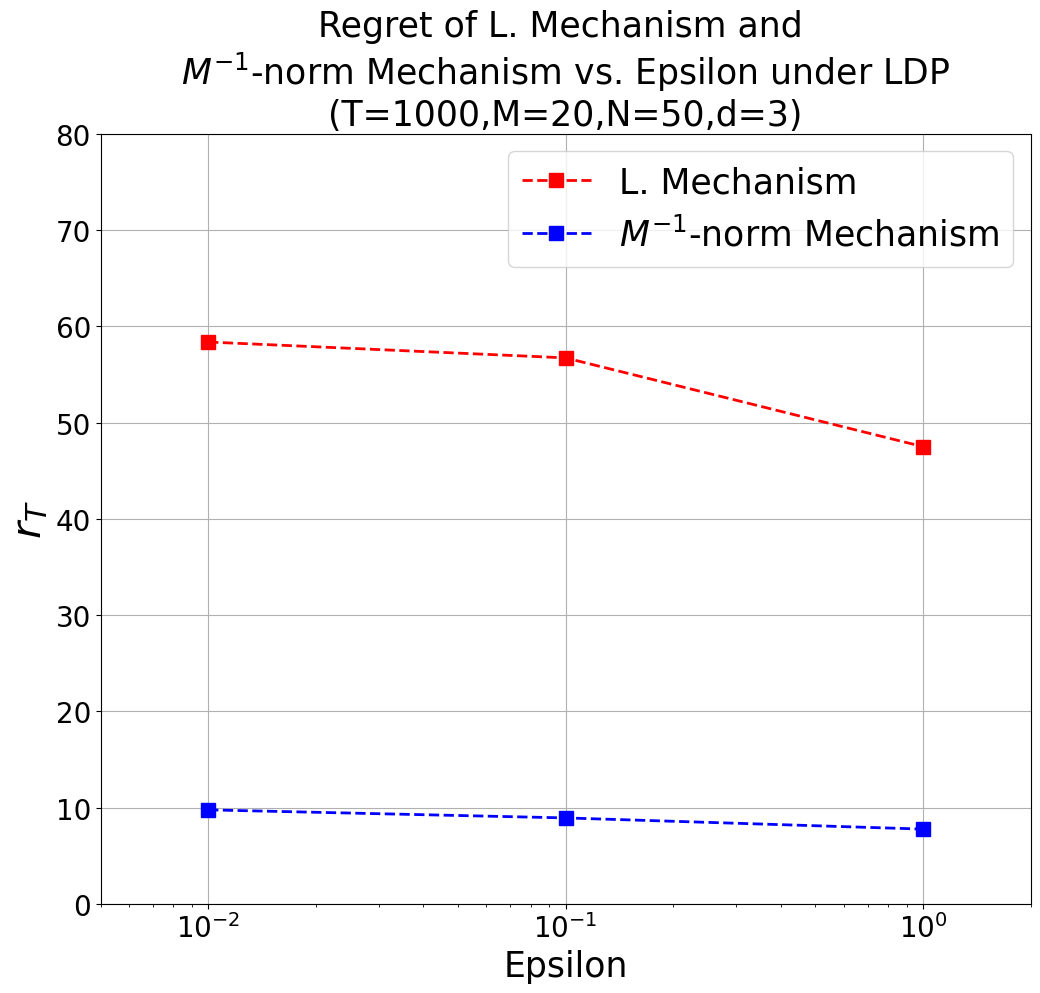

In [445]:
plt.figure(figsize= (12,10))
plt.semilogx(ep,Rt_ep_1,'rs--',label = 'L. Mechanism',linewidth=2, markersize=10)
plt.semilogx(ep,Rt_ep_2,'bs--',label = '$M^{-1}$-norm Mechanism',linewidth=2, markersize=10)
#plt.plot(xt,Rt_6,'r--',label = 'Alg6',linewidth=2, markersize=7)
#plt.plot(xt,Rt_7,'b-',label = 'Alg7',linewidth=2, markersize=7)
plt.xlabel('Epsilon',fontsize = 25)
plt.ylabel(r'$r_T$',fontsize = 30)
plt.title('Regret of L. Mechanism and \n$M^{-1}$-norm Mechanism vs. Epsilon under LDP\n(T=1000,M=20,N=50,d=3)',fontsize=25)
plt.ylim(0,80)
plt.xlim(0.005,2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=25)
plt.savefig(r'Regret of Alg6 & Alg7 vs Epsilon (T=1000,M=20,N=50,d=3).png',dpi=500)
plt.show

In [6]:
def ARSampling(M,epsi,d,n):
    xt = np.zeros(d)
    cov = M*2/epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize+n):
        xt_candidate = np.random.multivariate_normal(xt,cov)
        #multivariate_normal.pdf(xt_candidate,mean=xt,cov=cov)
        prob_accept = MHNFunc(xt_candidate,M,epsi,d)/MHNFunc(xt,M,epsi,d)
        if np.random.uniform(0,1) <min(prob_accept,1):
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

    
def MHNFunc_test(x,X,k,M,epsi,d):
    X[k]=x
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(X),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)

def MHNFunc(x,M,epsi,d):
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(x),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)




### Algorithm 9

In [7]:
def Algorithm9(T,M,N,d,U,Gvt,epi = None):
    if epi==None:
        epi = 1/np.sqrt(T)
    lamb = np.log2(T)/epi
    ita = np.sqrt(np.log(N)/T)
    err = 1e-10

    X = np.zeros((T,M,N))/N
    X[0] = np.ones((M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)
    n_len = int(np.log2(T))
    nLap = np.random.laplace(0,lamb,size=(n_len,N))
    V = np.zeros((M,T,N))

    #np.random.seed(202303019)

    for t in range(T):
        #print(X[t])

        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print('Lt = ',Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print('sumXL = ',sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print('min of Lt = ',min(sum(Lt[:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M
        if t<T-1:
            TLt = sum(Lt[:t+1])
            st = calSt(t)
            for iz in range(M):
                epsi_t = np.random.laplace(0,lamb,size=(st,N))
                V[iz][t] = sum(epsi_t) + TLt + sum(nLap[:n_len-st])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin(V[iz],N,ita)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt

def TreeAgg(lt,T,epsi):
    n_len = np.log2(T)
    lambd = n_len/epsi
    n = np.random.laplace(0,lambd,size=n_len)
    V = np.zeros(T)
    for t in range(T):
        Lt = sum(lt[:t])
        st = calSt(t)
        epsi_t = np.random.laplace(0,lambd,size=st)
        V[t] = sum(epsi_t) + Lt + sum(n[:n_len-st])
    return V

### Calculate St

In [8]:
def subcalSt(n):
    if n == 1:
        count = 0
    else:
        count = 1
        
    if int(n/2) !=1 and int(n/2) !=0:
        if int(n/2)%2 ==0:
            count = 0
            return subcalSt(int(n/2))
        else:
            count = 1
            count += subcalSt(int(n/2))
    return count


def calSt(n):
    return subcalSt(n) + n%2

In [9]:
def ARSampling_9(M,epsi,d,n,T):
    xt = np.zeros(d)
    cov = M*2*np.log2(T)/epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize+n):
        xt_candidate = np.random.multivariate_normal(xt,cov)
        prob_accept = MHNFunc_9(xt_candidate,M,epsi,d,T)/MHNFunc_9(xt,M,epsi,d,T)
        if np.random.uniform(0,1) <min(prob_accept,1):
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

    
def MHNFunc_test(x,X,k,M,epsi,d):
    X[k]=x
    if d ==1 :
        lamd = (2/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/2)*np.sqrt(HNorm(np.asarray(X),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)

def MHNFunc_9(x,M,epsi,d,T):
    if d ==1 :
        lamd = (2*np.log2(T)/epsi)*M*np.pi**(d/2)/(math.gamma(d/2+1))
    else:
        lamd = np.sqrt(np.linalg.det((2*np.log2(T)/epsi)*M))*np.pi**(d/2)/(math.gamma(d/2+1))
    return np.exp((-epsi/(2*np.log2(T)))*np.sqrt(HNorm(np.asarray(x),np.linalg.inv(M))[0]))/(math.gamma(d+1)*lamd)




In [10]:
def Algorithm11(T,M,N,d,U,Gvt,epi=None):
    if epi==None:
        epi = 1/np.sqrt(T)
    ita = np.sqrt(d/T)
    err = 1e-10

    X = np.zeros((T,M,N))
    X[0] = np.ones((M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)

    #np.random.seed(20230321)
    V = np.zeros((M,T,d))
    MU = MVEE(U)
    nLap = ARSampling_9(MU,epi,d,M*T,T)
    nLap = nLap.reshape(T,M,d)
    n_len = int(np.log2(T))
    epsi_t = ARSampling_9(MU,epi,d,n_len*M,T)
    epsi_t = epsi_t.reshape(M,n_len,d)

    for t in range(T):
        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print(Lt[t])

        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print(sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print(min(sum(Lt[0:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M

        H = np.eye(N)+np.dot(np.dot(U,MU),U.T)
        if t<T-1:
            TVt = sum(vt[:t+1])
            st = calSt(t)
            for iz in range(M):    
                V[iz][t] = sum(epsi_t[iz][:st]) + TVt + sum(nLap[t][:n_len-st])
                #print(gtj)
                #print(X[iz])
            #for iz in range(M):
                X[t+1][iz] = _argmin_11(V[iz],N,ita,H,U)
                #print(X[t+1][iz])
        else:
            break
        #print('\n')
    return Rt


### Algorithm 12

In [495]:
def Algorithm12(T,M,N,d,U,Gvt,epi = None):
    if epi==None:
        epi = 1/np.sqrt(T)
    ita = np.sqrt(d/T)
    err = 1e-10

    X = np.zeros((T,M,N))
    X[0] = np.ones((M,N))/N
    Lt = np.zeros((T,N))
    Rtj = np.zeros((T,M))
    Rt = np.zeros(T)

    #np.random.seed(20230321)
    V = np.zeros((M,T,d))
    MU = MVEE(U)
    nLap = ARSampling_9(MU,epi,d,M*T,T)
    nLap = nLap.reshape(T,M,d)
    n_len = int(np.log2(T))
    epsi_t = ARSampling_9(MU,epi,d,n_len*M,T)
    epsi_t = epsi_t.reshape(M,n_len,d)
    vt = np.zeros((T,d))

    #np.random.seed(202303019)

    for t in range(T):
        #print(X[t])

        vt = Gvt[t]
        Lt[t] = calLt(U,vt)
        #print('Lt = ',Lt[t])
        
        for j in range(M):
            sumXL = 0
            for k in range(t+1):
                #print(X[k][j])
                sumXL += np.dot(X[k][j],Lt[k].reshape(1,N).T)
                #print('sumXL = ',sumXL)
            if t==0:
                Rtj[t][j] = sumXL - min(Lt[t])
                #print(min(Lt[t]))
            else:
                Rtj[t][j] = sumXL - min(sum(Lt[:t+1]))
                #print('min of Lt = ',min(sum(Lt[:t+1])))
        #print(Rtj[t])
        Rt[t] = sum(Rtj[t])/M
        if t<T-1:
            k = 1
            if k<d:
                if np.linalg.matrix_rank(np.concatenate(U_hat,Lt[t].T,axis=1))==np.linalg.matrix_rank(U_hat):
                    vt[t] = np.dot(Lt[t],np.linalg.inv(U_hat))
                    MU = MVEE(U_hat)
                    H = np.eye(N)+np.dot(np.dot(U_hat,MU),U.T)
                    TVt = sum(vt[:t+1])
                    st = calSt(t)
                    for iz in range(M):
                        epsi_t = np.random.laplace(0,lamb,size=(st,N))
                        V[iz][t] = sum(epsi_t[iz][:st]) + TVt + sum(nLap[t][:n_len-st])
                        X[t+1][iz] = _argmin_11(V[iz],N,ita,H,U)
                    break
                else:
                    k+=1
                    U_hat = np.concatenate(U_hat,Lt[t].T,axis=1)
                    MU = MVEE(U_hat)
                    vt[t] = np.dot(Lt[t],np.linalg.inv(U_hat))
                    H = np.eye(N)+np.dot(np.dot(U_hat,MU),U.T)
                    TVt = sum(vt[:t+1])
                    st = calSt(t)
                    for iz in range(M):
                        epsi_t = np.random.laplace(0,lamb,size=(st,N))
                        V[iz][t] = sum(epsi_t[iz][:st]) + TVt + sum(nLap[t][:n_len-st])
                        X[t+1][iz] = _argmin_11(V[iz],N,ita,H,U)
            else:
                
        else:
            break
        #print('\n')
    return Rt

def TreeAgg(lt,T,epsi):
    n_len = np.log2(T)
    lambd = n_len/epsi
    n = np.random.laplace(0,lambd,size=n_len)
    V = np.zeros(T)
    for t in range(T):
        Lt = sum(lt[:t])
        st = calSt(t)
        epsi_t = np.random.laplace(0,lambd,size=st)
        V[t] = sum(epsi_t) + Lt + sum(n[:n_len-st])
    return V

IndentationError: expected an indented block (571225316.py, line 74)

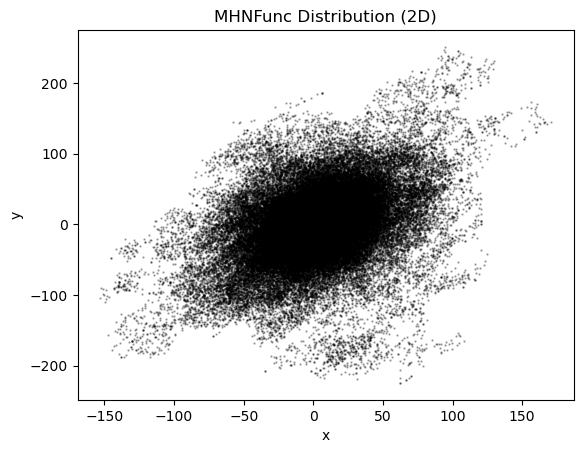

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

def MHNFunc(x, M, epsi, d):
    if d == 1:
        lamd = (2 / epsi) * M * np.pi**(d / 2) / (np.math.gamma(d / 2 + 1))
    else:
        lamd = np.sqrt(np.linalg.det((2 / epsi) * M)) * np.pi**(d / 2) / (np.math.gamma(d / 2 + 1))
    return np.exp((-epsi / 2) * np.sqrt(HNorm(np.asarray(x), np.linalg.inv(M))[0])) / (np.math.gamma(d + 1) * lamd)

def ARSampling(M, epsi, d, n):
    xt = np.zeros(d)
    cov = M * 2 / epsi
    BurnSize = 10000
    samples = []
    for i in range(BurnSize + n):
        xt_candidate = np.random.multivariate_normal(xt, cov)
        prob_accept = min(MHNFunc(xt_candidate, M, epsi, d) / MHNFunc(xt, M, epsi, d), 1)
        if np.random.uniform(0, 1) < prob_accept:
            xt = xt_candidate
        samples.append(xt)
    return np.asarray(samples[BurnSize:])

# Define distribution parameters
M = np.array([[1, 0.5], [0.5, 2]])
epsi = 0.1
d = 2
n = 100000

# Generate samples
samples = ARSampling(M, epsi, d, n)

# KDE plot
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(samples)
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
xy = np.column_stack([X.ravel(), Y.ravel()])
Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
plt.contourf(X, Y, Z, levels=20, cmap='cool')
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, alpha=0.3, color='black')
plt.title("MHNFunc Distribution (2D)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


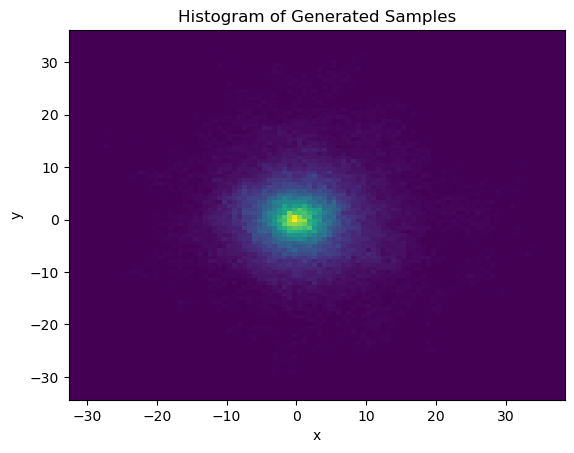

In [106]:
import numpy as np
import matplotlib.pyplot as plt

def mcmc_sampler(p, q_sampler, n_samples, x_init):
    """
    Generate random samples from the distribution p using Metropolis-Hastings algorithm.

    Parameters:
        p: function
            The target distribution from which we want to generate random samples.
        q_sampler: function
            A function that takes in the current state and returns a new state sampled from the proposal distribution.
        n_samples: int
            The number of samples to generate.
        x_init: numpy.ndarray
            The initial state.

    Returns:
        numpy.ndarray
            An array of size n_samples x d, where d is the dimensionality of the target distribution p.
    """
    d = len(x_init)
    x = np.zeros((n_samples, d))
    x[0] = x_init
    for i in range(1, n_samples):
        x_star = q_sampler(x[i-1])
        acceptance_prob = min(1, p(x_star) / p(x[i-1]))
        if np.random.uniform(0, 1) < acceptance_prob:
            x[i] = x_star
        else:
            x[i] = x[i-1]
    return x

# define the target distribution we want to sample from
def MHNFunc(x, M, epsi, d):
    if d == 1:
        lamd = (2/epsi) * M * np.pi**(d/2) / math.gamma(d/2+1)
    else:
        lamd = np.sqrt(np.linalg.det((2/epsi) * M)) * np.pi**(d/2) / math.gamma(d/2+1)
    return np.exp((-epsi/2) * np.sqrt(HNorm(np.asarray(x), np.linalg.inv(M))[0])) / (math.gamma(d+1) * lamd)

# define the proposal distribution
def q_sampler(x):
    return np.random.multivariate_normal(x, np.identity(d))

# set the parameters
d = 2
M = np.identity(d)
epsi = 0.5
x_init = np.zeros(d)
n_samples = 100000

# generate random samples using Metropolis-Hastings algorithm
samples = mcmc_sampler(lambda x: MHNFunc(x, M, epsi, d), q_sampler, n_samples, x_init)

# plot histogram of generated samples
plt.hist2d(samples[:, 0], samples[:, 1], bins=100, density=True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Histogram of Generated Samples')
plt.show()
